# Lab 6: Induction Heads — BLOOM vs JEPA-finetuned BLOOM

**Question:** Does LLM-JEPA fine-tuning change the induction head landscape?

LLM-JEPA adds a cosine-similarity embedding alignment loss (between user and assistant representations) on top of standard LM loss. The architecture is unchanged — only the training signal differs. Any differences in induction heads reveal how the JEPA objective reshapes internal attention circuits.

**Setup:**
- Base model: `bigscience/bloom-560m` (24 layers, 16 heads)
- JEPA model: Same BLOOM-560M fine-tuned with JEPA objective
- Analysis: Induction head detection, visualization, comparison

In [4]:
!pip install -q transformer_lens transformers torch numpy=="1.26.4" matplotlib seaborn pandas datasets

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import pandas as pd

from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

Using device: cuda


## 1. Model Loading

Two backends:
- **TransformerLens** (`HookedTransformer`) for clean attention cache extraction
- **HuggingFace native** (`output_attentions=True`) as fallback for fine-tuned models

In [2]:
from transformer_lens import HookedTransformer


@dataclass
class ModelWrapper:
    """Unified interface for TransformerLens and HuggingFace models."""
    name: str
    n_layers: int
    n_heads: int
    d_model: int
    backend: str  # 'tl' or 'hf'
    _tl_model: Optional[HookedTransformer] = None
    _hf_model: Optional[AutoModelForCausalLM] = None
    _tokenizer: Optional[AutoTokenizer] = None


def load_model_tl(model_name: str, display_name: str = None) -> ModelWrapper:
    """Load model via TransformerLens."""
    display_name = display_name or model_name
    print(f"Loading {display_name} (TransformerLens)...")
    model = HookedTransformer.from_pretrained(model_name, device=device)
    wrapper = ModelWrapper(
        name=display_name,
        n_layers=model.cfg.n_layers,
        n_heads=model.cfg.n_heads,
        d_model=model.cfg.d_model,
        backend='tl',
        _tl_model=model,
    )
    print(f"  {wrapper.n_layers} layers, {wrapper.n_heads} heads, d_model={wrapper.d_model}")
    return wrapper


def load_model_hf(model_path: str, display_name: str = None, tokenizer_name: str = None) -> ModelWrapper:
    """Load model via HuggingFace (for fine-tuned models)."""
    display_name = display_name or model_path
    tokenizer_name = tokenizer_name or model_path
    print(f"Loading {display_name} (HuggingFace)...")
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    model.eval()
    config = model.config
    wrapper = ModelWrapper(
        name=display_name,
        n_layers=config.n_layer if hasattr(config, 'n_layer') else config.num_hidden_layers,
        n_heads=config.n_head if hasattr(config, 'n_head') else config.num_attention_heads,
        d_model=config.hidden_size,
        backend='hf',
        _hf_model=model,
        _tokenizer=tokenizer,
    )
    print(f"  {wrapper.n_layers} layers, {wrapper.n_heads} heads, d_model={wrapper.d_model}")
    return wrapper


def get_attention_patterns(wrapper: ModelWrapper, text: str) -> Tuple[List[str], torch.Tensor]:
    """
    Extract attention patterns from either backend.
    Returns: (tokens, attentions) where attentions is [n_layers, n_heads, seq_len, seq_len]
    """
    if wrapper.backend == 'tl':
        model = wrapper._tl_model
        toks = model.to_tokens(text)
        _, cache = model.run_with_cache(toks)
        str_tokens = model.to_str_tokens(text)
        attn_stack = torch.stack(
            [cache["pattern", layer][0] for layer in range(wrapper.n_layers)]
        )
        return str_tokens, attn_stack
    else:
        tokenizer = wrapper._tokenizer
        model = wrapper._hf_model
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
        str_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        attn_stack = torch.stack([a[0] for a in outputs.attentions])
        return str_tokens, attn_stack

## 2. Test Examples (Multilingual)

In [3]:
@dataclass
class Example:
    text: str
    language: str
    description: str

EXAMPLES = {
    "abab": Example(" A B C D E F G H A B C D E F G H A B", "Pattern", "Pure ABAB repetition"),
    "en": Example("The cat sat on the mat. The cat sat on the mat.", "English", "Repeated sentence"),
    "es": Example("El gato negro corre rápido. El gato negro corre rápido.", "Spanish", "Repeated sentence"),
    "fr": Example("Le chat dort sur le lit. Le chat dort sur le lit.", "French", "Repeated sentence"),
    "zh": Example("我喜欢吃苹果和香蕉。我喜欢吃苹果和香蕉。", "Chinese", "Repeated sentence"),
    "de": Example("Der Hund läuft im Park. Der Hund läuft im Park.", "German", "Repeated sentence"),
    "random": Example("xq7 mn2 pz9 ab3 xq7 mn2 pz9 ab3 xq7", "Random", "Random tokens repeated"),
}

pd.DataFrame([{"key": k, "lang": e.language, "text": e.text[:50]} for k, e in EXAMPLES.items()])

,key,lang,text
0,abab,Pattern,A B C D E F G H A B C D E F G H A B
1,en,English,The cat sat on the mat. The cat sat on the mat.
2,es,Spanish,El gato negro corre rápido. El gato negro corr...
3,fr,French,Le chat dort sur le lit. Le chat dort sur le lit.
4,zh,Chinese,我喜欢吃苹果和香蕉。我喜欢吃苹果和香蕉。
5,de,German,Der Hund läuft im Park. Der Hund läuft im Park.
6,random,Random,xq7 mn2 pz9 ab3 xq7 mn2 pz9 ab3 xq7


## 3. Induction Head Detection

In [4]:
def detect_repeat_offset(tokens: List[str]) -> int:
    """Auto-detect the offset of repeated patterns in a token list."""
    seq_len = len(tokens)
    best_offset, best_rate = seq_len // 2, 0
    for offset in range(2, seq_len // 2 + 1):
        matches = sum(1 for i in range(offset, seq_len) if tokens[i] == tokens[i - offset])
        rate = matches / (seq_len - offset)
        if rate > best_rate:
            best_rate = rate
            best_offset = offset
    return best_offset


def compute_induction_score(attention: torch.Tensor, offset: int) -> float:
    """Mean attention on the induction diagonal (offset positions back)."""
    seq_len = attention.shape[0]
    if offset >= seq_len:
        return 0.0
    diag = [attention[i, i - offset].item() for i in range(offset, seq_len)]
    return np.mean(diag) if diag else 0.0


def compute_prefix_matching_score(attention: torch.Tensor, token_ids: List) -> float:
    """How much does the head attend to positions where the previous token matches?"""
    seq_len = attention.shape[0]
    if seq_len < 3:
        return 0.0
    total, count = 0.0, 0
    for q in range(2, seq_len):
        prev = token_ids[q - 1]
        matches = [k for k in range(1, q) if token_ids[k - 1] == prev]
        if matches:
            total += sum(attention[q, k].item() for k in matches)
            count += 1
    return total / count if count > 0 else 0.0


def detect_induction_heads(
    wrapper: ModelWrapper, text: str, offset: int = None, threshold: float = 0.1
) -> pd.DataFrame:
    """Detect induction heads across all layers/heads. Returns sorted DataFrame."""
    str_tokens, attn_stack = get_attention_patterns(wrapper, text)

    if offset is None:
        offset = detect_repeat_offset(str_tokens)

    if wrapper.backend == 'tl':
        token_ids = wrapper._tl_model.to_tokens(text)[0].cpu().tolist()
    else:
        token_ids = wrapper._tokenizer(text, return_tensors="pt")["input_ids"][0].cpu().tolist()

    results = []
    for layer in range(wrapper.n_layers):
        for head in range(wrapper.n_heads):
            attn = attn_stack[layer, head]
            ind_score = compute_induction_score(attn, offset)
            pfx_score = compute_prefix_matching_score(attn, token_ids)
            combined = (ind_score + pfx_score) / 2
            results.append({
                'Layer': layer, 'Head': head,
                'Induction Score': ind_score,
                'Prefix Match Score': pfx_score,
                'Combined Score': combined,
            })
    return pd.DataFrame(results).sort_values('Combined Score', ascending=False)

## 4. Visualization

In [5]:
def plot_induction_heatmap(df: pd.DataFrame, title: str, figsize=(7, 8)):
    """Heatmap of induction scores across layers x heads."""
    n_layers = df['Layer'].max() + 1
    n_heads = df['Head'].max() + 1
    matrix = np.zeros((n_layers, n_heads))
    for _, row in df.iterrows():
        matrix[int(row['Layer']), int(row['Head'])] = row['Induction Score']
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(matrix, cmap='Reds', aspect='auto')
    ax.set_xlabel('Head'); ax.set_ylabel('Layer')
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    return fig, matrix


def plot_attention_head(attn_stack: torch.Tensor, tokens: List[str], layer: int, head: int, ax=None):
    """Plot a single attention head's pattern."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    attn = attn_stack[layer, head].detach().cpu().numpy()
    ax.imshow(attn, cmap='Blues', aspect='auto')
    ax.set_xticks(range(len(tokens))); ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=7)
    ax.set_yticklabels(tokens, fontsize=7)
    ax.set_title(f'L{layer}H{head}')
    ax.set_xlabel('Key'); ax.set_ylabel('Query')
    return ax


def plot_top_heads(wrapper: ModelWrapper, text: str, df: pd.DataFrame, n=6):
    """Visualize attention patterns of top N induction heads."""
    tokens, attn_stack = get_attention_patterns(wrapper, text)
    top = df.head(n)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = axes.flatten() if n > 1 else [axes]
    for i, (_, row) in enumerate(top.iterrows()):
        plot_attention_head(attn_stack, tokens, int(row['Layer']), int(row['Head']), ax=axes[i])
        axes[i].set_title(f"L{int(row['Layer'])}H{int(row['Head'])} (score={row['Induction Score']:.3f})")
    for i in range(n, len(axes)):
        axes[i].set_visible(False)
    fig.suptitle(f'Top {n} Induction Heads — {wrapper.name}', fontsize=13)
    plt.tight_layout()
    return fig


def plot_comparison(df_base, df_jepa, matrix_base, matrix_jepa, figsize=(18, 7)):
    """Side-by-side + difference heatmaps."""
    diff = matrix_jepa - matrix_base
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    im0 = axes[0].imshow(matrix_base, cmap='Reds', aspect='auto')
    axes[0].set_title('Base BLOOM'); axes[0].set_xlabel('Head'); axes[0].set_ylabel('Layer')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(matrix_jepa, cmap='Reds', aspect='auto')
    axes[1].set_title('JEPA BLOOM'); axes[1].set_xlabel('Head'); axes[1].set_ylabel('Layer')
    plt.colorbar(im1, ax=axes[1])

    vmax = max(abs(diff.min()), abs(diff.max()), 1e-8)
    im2 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[2].set_title('Difference (JEPA - Base)'); axes[2].set_xlabel('Head'); axes[2].set_ylabel('Layer')
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    return fig

---
## 5. Analyze Base BLOOM-560M

In [6]:
bloom_base = load_model_tl("bloom-560m", "BLOOM-560M (base)")

Loading BLOOM-560M (base) (TransformerLens)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Loaded pretrained model bloom-560m into HookedTransformer
  24 layers, 16 heads, d_model=1024


In [7]:
base_scores = detect_induction_heads(bloom_base, EXAMPLES["abab"].text)
print("Top 10 induction head candidates (base BLOOM):")
base_scores.head(10)

Top 10 induction head candidates (base BLOOM):


,Layer,Head,Induction Score,Prefix Match Score,Combined Score
30,1,14,0.344993,0.358738,0.351865
60,3,12,0.290235,0.303868,0.297052
9,0,9,0.244532,0.259649,0.252091
120,7,8,0.235715,0.265202,0.250458
110,6,14,0.241000,0.235813,0.238407
5,0,5,0.204246,0.208676,0.206461
57,3,9,0.130738,0.154417,0.142577
186,11,10,0.176120,0.101953,0.139036
301,18,13,0.179875,0.090290,0.135083
332,20,12,0.160577,0.076454,0.118516


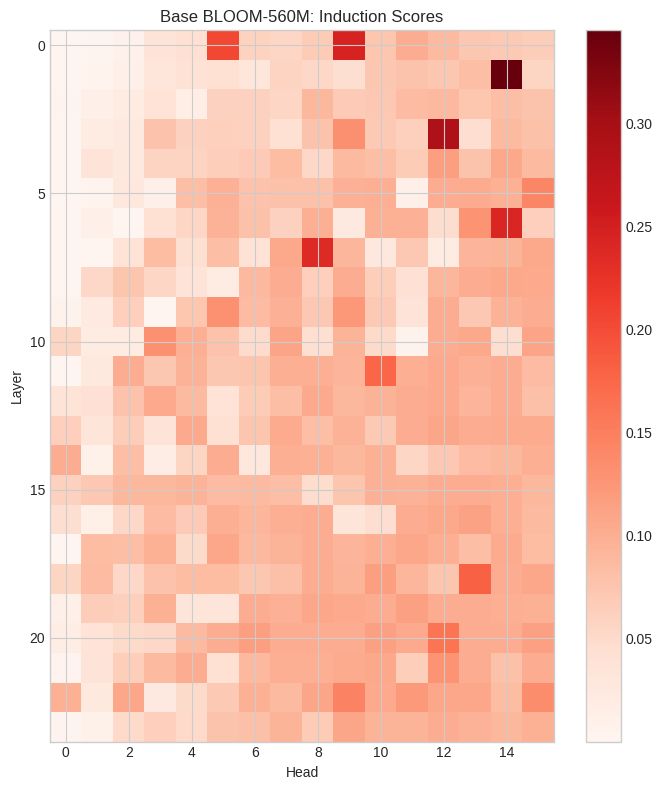

In [8]:
fig_base, matrix_base = plot_induction_heatmap(base_scores, "Base BLOOM-560M: Induction Scores")
plt.show()

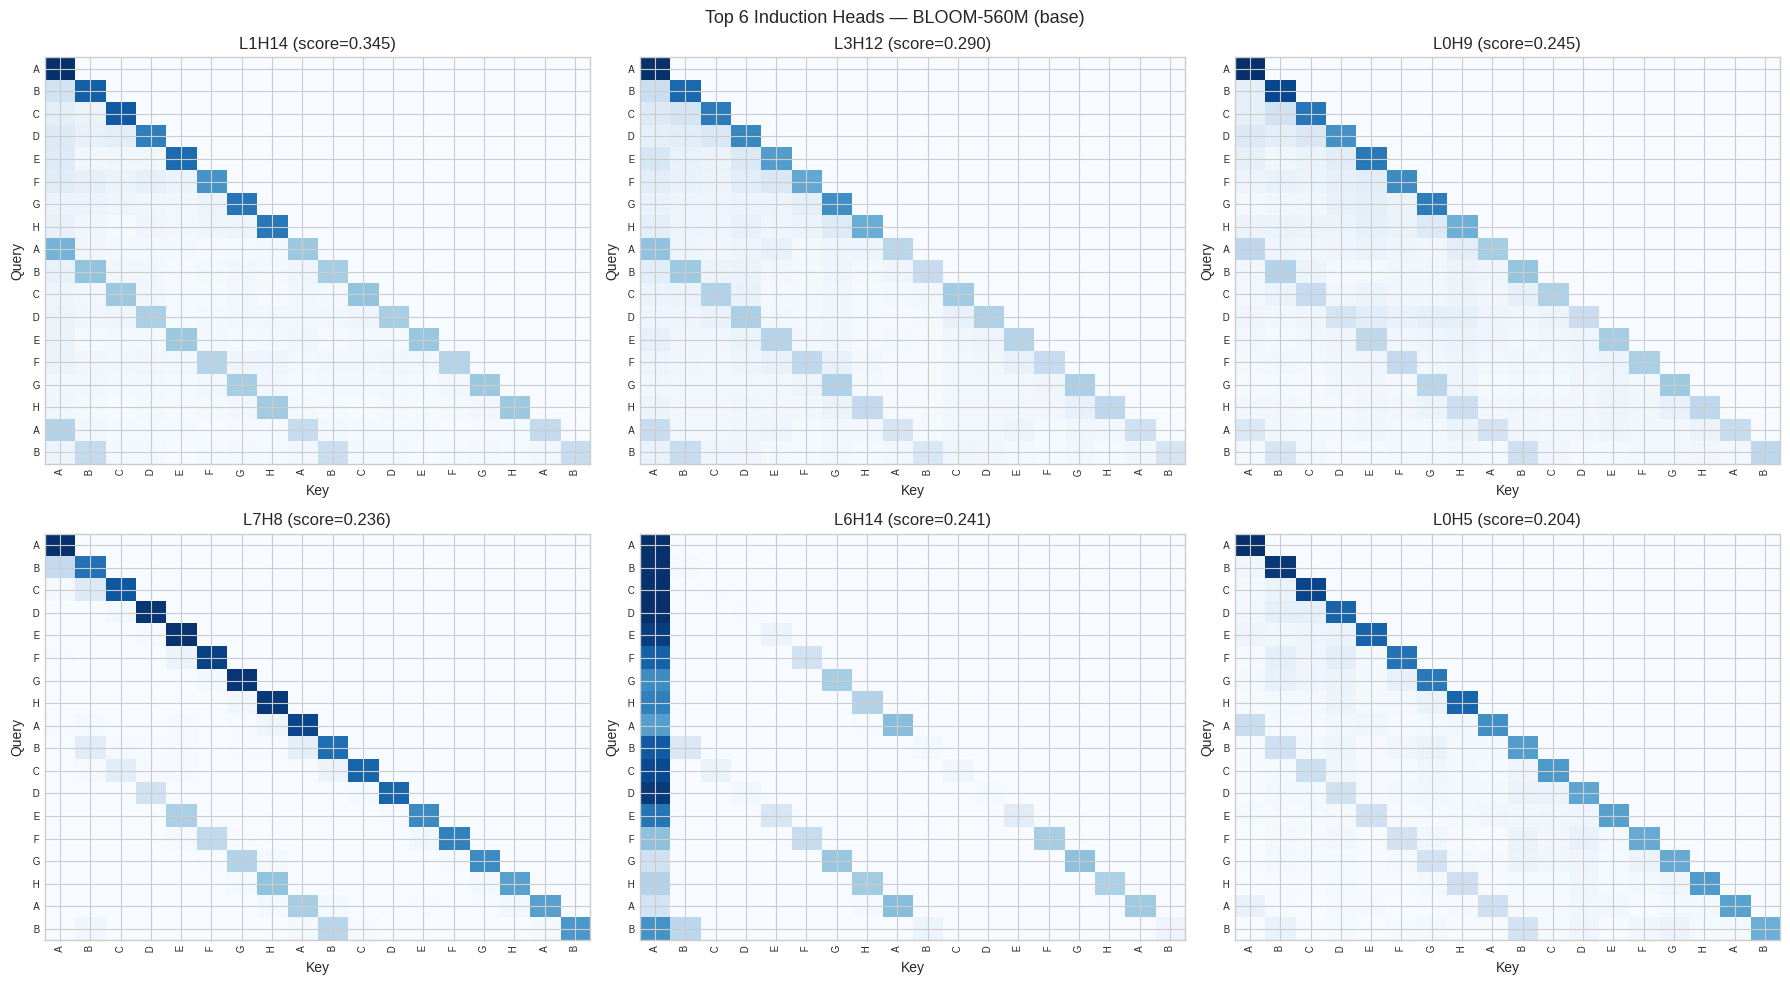

In [9]:
plot_top_heads(bloom_base, EXAMPLES["abab"].text, base_scores, n=6)
plt.show()

In [10]:
# Cross-language induction head consistency
base_cross_lang = {}
for key, ex in EXAMPLES.items():
    base_cross_lang[key] = detect_induction_heads(bloom_base, ex.text)

for key, df in base_cross_lang.items():
    top = df.head(5)
    heads = [(int(r['Layer']), int(r['Head'])) for _, r in top.iterrows()]
    print(f"{key:8s} ({EXAMPLES[key].language:8s}): {heads}")

abab     (Pattern ): [(1, 14), (3, 12), (0, 9), (7, 8), (6, 14)]
en       (English ): [(7, 8), (3, 12), (11, 10), (21, 14), (0, 9)]
es       (Spanish ): [(7, 8), (3, 12), (1, 14), (11, 10), (6, 14)]
fr       (French  ): [(7, 8), (3, 12), (11, 10), (1, 14), (0, 9)]
zh       (Chinese ): [(3, 12), (1, 14), (7, 8), (0, 11), (0, 9)]
de       (German  ): [(1, 14), (7, 8), (3, 12), (0, 9), (11, 10)]
random   (Random  ): [(3, 12), (1, 14), (0, 9), (11, 10), (7, 8)]


---
## 6. JEPA Fine-tuning

Minimal single-GPU JEPA fine-tuning of BLOOM-560M on **translation pairs**.  
Adapted from [LLM-JEPA](https://github.com/galilai-group/llm-jepa).  

**Key insight:** BLOOM is already multilingual. Translation pairs give the JEPA loss a 
semantically meaningful alignment target — source and target sentences that share meaning — 
rather than forcing arbitrary Q/A structure onto a base model.

**Loss:** `total = lm_loss + λ * (1 - cos_sim(source_emb, target_emb))`  
**Data:** English↔French, English↔Spanish, English↔German translation pairs from OPUS-100.

In [28]:
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
import os
from tqdm.auto import tqdm

In [30]:
from datasets import load_dataset, concatenate_datasets

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load translation pairs from OPUS-100 (multiple language pairs)
lang_pairs = ["en-fr", "en-es", "en-wa"]
all_data = []
for pair in lang_pairs:
    src, tgt = pair.split("-")
    ds = load_dataset("Helsinki-NLP/opus-100", pair, split="train[:2000]")
    for item in ds:
        all_data.append({
            "source": item["translation"][src],
            "target": item["translation"][tgt],
            "pair": pair,
        })
print(f"Loaded {len(all_data)} translation pairs across {lang_pairs}")


class TranslationJEPADataset(Dataset):
    """Translation pairs for JEPA training. Source/target embeddings should align."""
    def __init__(self, data, tokenizer, max_len=128):
        self.pairs = []
        for item in data:
            src, tgt, pair = item["source"], item["target"], item["pair"]
            src_lang, tgt_lang = pair.split("-")
            full = f"{src} = {tgt}"
            self.pairs.append((full, src, tgt))
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        full, source, target = self.pairs[idx]
        full_enc = self.tokenizer(full, truncation=True, max_length=self.max_len,
                                  padding="max_length", return_tensors="pt")
        src_enc = self.tokenizer(source, truncation=True, max_length=self.max_len,
                                 padding="max_length", return_tensors="pt")
        tgt_enc = self.tokenizer(target, truncation=True, max_length=self.max_len,
                                 padding="max_length", return_tensors="pt")
        return {
            "full_ids": full_enc["input_ids"].squeeze(0),
            "full_mask": full_enc["attention_mask"].squeeze(0),
            "user_ids": src_enc["input_ids"].squeeze(0),
            "user_mask": src_enc["attention_mask"].squeeze(0),
            "asst_ids": tgt_enc["input_ids"].squeeze(0),
            "asst_mask": tgt_enc["attention_mask"].squeeze(0),
        }


import random
random.shuffle(all_data)
dataset = TranslationJEPADataset(all_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
print(f"Dataset: {len(dataset)} examples, {len(dataloader)} batches")
print(f"Sample: '{all_data[0]['source']}' → '{all_data[0]['target']}' ({all_data[0]['pair']})")

en-wa/test-00000-of-00001.parquet:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

en-wa/train-00000-of-00001.parquet:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

en-wa/validation-00000-of-00001.parquet:   0%|          | 0.00/50.1k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/104496 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Loaded 6000 translation pairs across ['en-fr', 'en-es', 'en-wa']
Dataset: 6000 examples, 750 batches
Sample: 'White on black' → 'Blanc so noer' (en-wa)


In [37]:
def get_last_real_token_embedding(hidden_states, attention_mask):
    """Extract embedding at the last non-padding token position."""
    lengths = attention_mask.sum(dim=1) - 1
    batch_idx = torch.arange(hidden_states.size(0), device=hidden_states.device)
    return hidden_states[batch_idx, lengths]


def jepa_train(
    model_name="bigscience/bloom-560m",
    output_dir="./bloom-560m-jepa",
    dataloader=dataloader,
    epochs=3,
    lr=5e-6,
    lbd=5,
    grad_accum=4,        # effective batch = 8 * 4 = 32
    log_every=10,
    patience=8,
):
    """JEPA fine-tuning on translation pairs with early stopping on LM loss."""
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32).to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = (epochs * len(dataloader)) // grad_accum
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=total_steps // 5, num_training_steps=total_steps
    )
    scaler = torch.amp.GradScaler("cuda")

    history = []
    step = 0
    accum_lm, accum_jepa = 0.0, 0.0
    best_lm_loss = float('inf')
    no_improve_count = 0

    for epoch in range(epochs):
        epoch_lm, epoch_jepa = 0, 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        stopped_early = False

        for batch_idx, batch in enumerate(pbar):
            full_ids = batch["full_ids"].to(device)
            full_mask = batch["full_mask"].to(device)
            src_ids = batch["user_ids"].to(device)
            src_mask = batch["user_mask"].to(device)
            tgt_ids = batch["asst_ids"].to(device)
            tgt_mask = batch["asst_mask"].to(device)

            with torch.amp.autocast("cuda"):
                # LM loss on full "source = target" sequence
                outputs_full = model(
                    input_ids=full_ids, attention_mask=full_mask,
                    labels=full_ids, output_hidden_states=True
                )
                lm_loss = outputs_full.loss

                # JEPA loss: align source & target language embeddings
                outputs_src = model(input_ids=src_ids, attention_mask=src_mask, output_hidden_states=True)
                outputs_tgt = model(input_ids=tgt_ids, attention_mask=tgt_mask, output_hidden_states=True)

                src_emb = get_last_real_token_embedding(outputs_src.hidden_states[-1], src_mask)
                tgt_emb = get_last_real_token_embedding(outputs_tgt.hidden_states[-1], tgt_mask)

                cos_sim = F.cosine_similarity(src_emb, tgt_emb, dim=-1)
                jepa_loss = (1.0 - cos_sim).mean()

                total_loss = (lm_loss + lbd * jepa_loss) / grad_accum

            scaler.scale(total_loss).backward()

            accum_lm += lm_loss.item() / grad_accum
            accum_jepa += jepa_loss.item() / grad_accum
            epoch_lm += lm_loss.item()
            epoch_jepa += jepa_loss.item()

            if (batch_idx + 1) % grad_accum == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
                step += 1

                if step % log_every == 0:
                    history.append({
                        'step': step, 'lm_loss': accum_lm,
                        'jepa_loss': accum_jepa, 'total_loss': accum_lm + lbd * accum_jepa,
                    })
                    if accum_lm < best_lm_loss:
                        best_lm_loss = accum_lm
                        no_improve_count = 0
                        os.makedirs(output_dir, exist_ok=True)
                        model.save_pretrained(output_dir)
                        tokenizer.save_pretrained(output_dir)
                    else:
                        no_improve_count += 1

                    if no_improve_count >= patience:
                        print(f"\nEarly stopping at step {step}. Best LM loss: {best_lm_loss:.4f}")
                        stopped_early = True

                accum_lm, accum_jepa = 0.0, 0.0

            pbar.set_postfix(lm=f"{lm_loss.item():.3f}", jepa=f"{jepa_loss.item():.3f}", step=step)
            if stopped_early:
                break

        n = max(batch_idx + 1, 1)
        print(f"Epoch {epoch+1}: LM={epoch_lm/n:.4f}, JEPA={epoch_jepa/n:.4f}")
        if stopped_early:
            break

    if not stopped_early:
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

    print(f"Best model saved to {output_dir} (best LM loss: {best_lm_loss:.4f})")
    return model, pd.DataFrame(history)

In [38]:
# Free base model memory before training
if bloom_base._tl_model is not None:
    del bloom_base._tl_model
    bloom_base._tl_model = None
torch.cuda.empty_cache()

# Translation JEPA: lr=5e-6, lbd=0.1, effective batch=32, 3 epochs
jepa_model_hf, train_history = jepa_train(epochs=3)

Epoch 1/3:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1: LM=5.6322, JEPA=0.0136


Epoch 2/3:   0%|          | 0/750 [00:00<?, ?it/s]


Early stopping at step 190. Best LM loss: 0.6115
Epoch 2: LM=1.0172, JEPA=0.0042
Best model saved to ./bloom-560m-jepa (best LM loss: 0.6115)


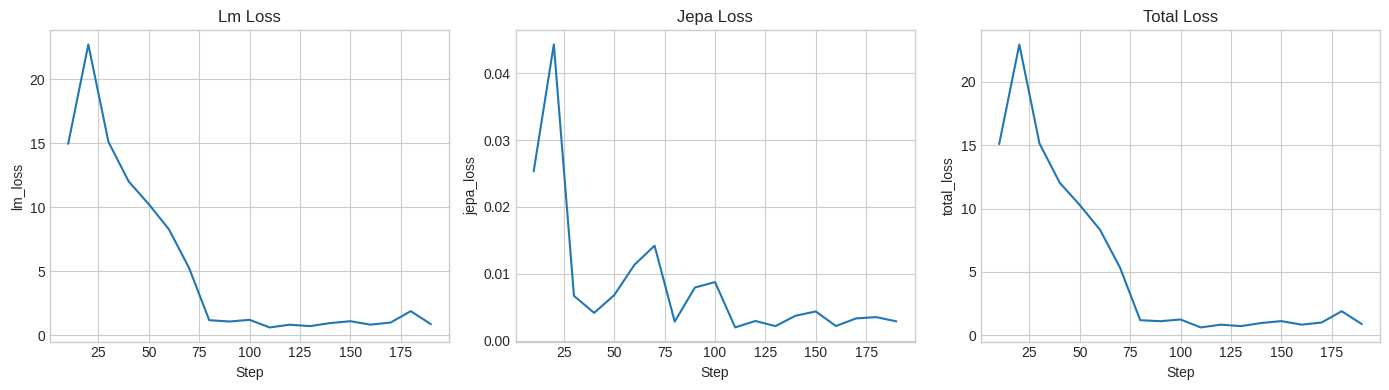

In [39]:
if len(train_history) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for i, col in enumerate(['lm_loss', 'jepa_loss', 'total_loss']):
        axes[i].plot(train_history['step'], train_history[col])
        axes[i].set_xlabel('Step'); axes[i].set_ylabel(col)
        axes[i].set_title(col.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()

---
## 7. Analyze JEPA-finetuned BLOOM

In [40]:
del jepa_model_hf
torch.cuda.empty_cache()

bloom_base = load_model_tl("bloom-560m", "BLOOM-560M (base)")
bloom_jepa = load_model_hf("./bloom-560m-jepa", "BLOOM-560M (JEPA)", tokenizer_name="bigscience/bloom-560m")

Loading BLOOM-560M (base) (TransformerLens)...


Loaded pretrained model bloom-560m into HookedTransformer
  24 layers, 16 heads, d_model=1024
Loading BLOOM-560M (JEPA) (HuggingFace)...
  24 layers, 16 heads, d_model=1024


In [41]:
jepa_scores = detect_induction_heads(bloom_jepa, EXAMPLES["abab"].text)
print("Top 10 induction head candidates (JEPA BLOOM):")
jepa_scores.head(10)

Top 10 induction head candidates (JEPA BLOOM):


,Layer,Head,Induction Score,Prefix Match Score,Combined Score
30,1,14,0.337976,0.355265,0.346621
60,3,12,0.290796,0.302639,0.296718
110,6,14,0.253403,0.271278,0.262340
9,0,9,0.244495,0.259616,0.252056
120,7,8,0.214862,0.241077,0.227970
5,0,5,0.204285,0.208720,0.206502
186,11,10,0.211104,0.146289,0.178697
57,3,9,0.133481,0.157996,0.145739
332,20,12,0.179050,0.092052,0.135551
95,5,15,0.142252,0.106730,0.124491


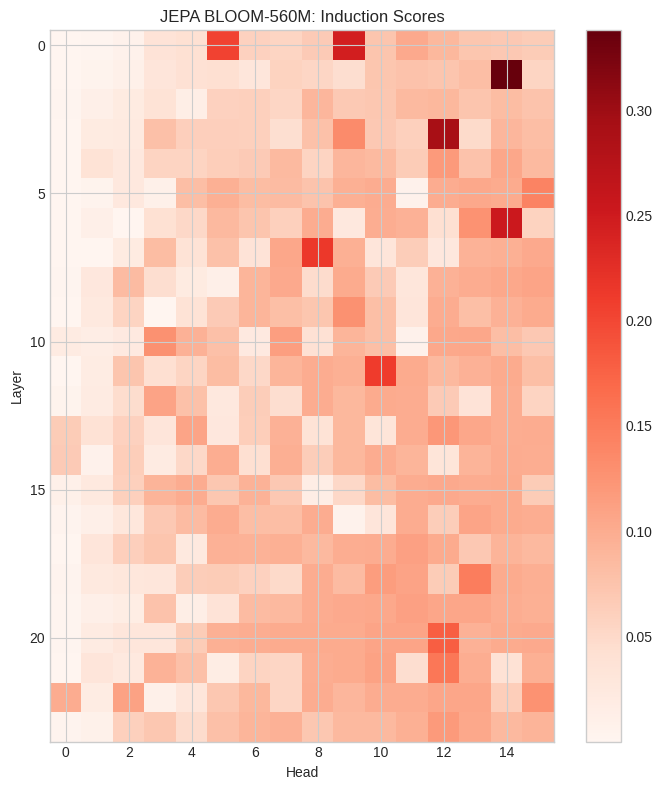

In [42]:
fig_jepa, matrix_jepa = plot_induction_heatmap(jepa_scores, "JEPA BLOOM-560M: Induction Scores")
plt.show()

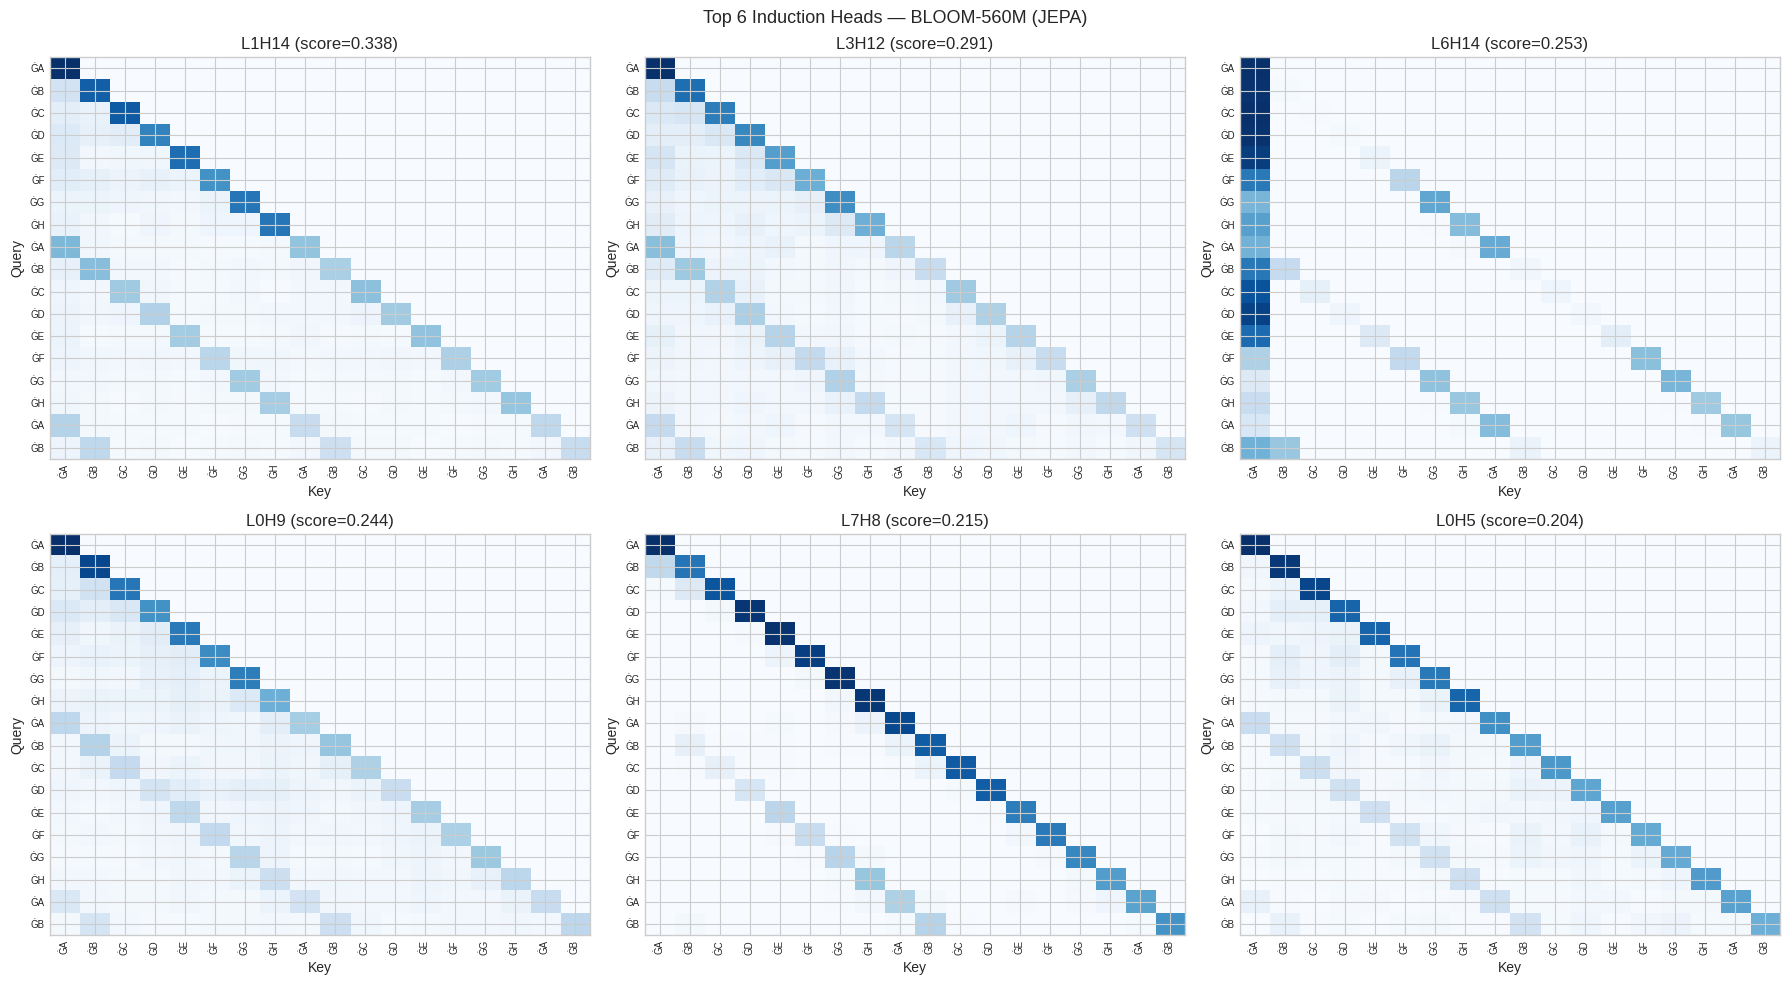

In [43]:
plot_top_heads(bloom_jepa, EXAMPLES["abab"].text, jepa_scores, n=6)
plt.show()

---
## 8. Comparison: Base vs JEPA

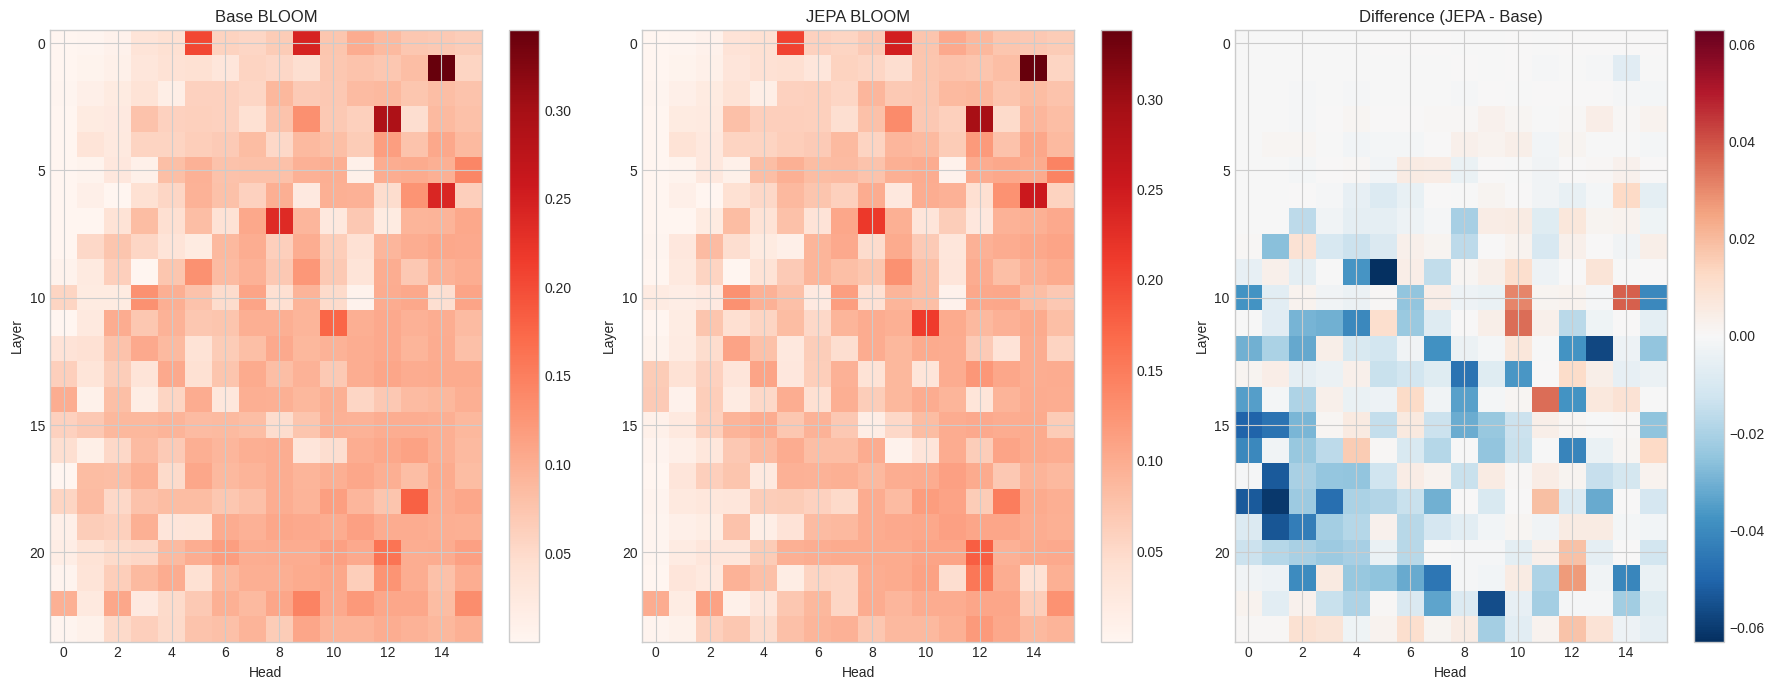

In [44]:
base_scores = detect_induction_heads(bloom_base, EXAMPLES["abab"].text)
_, matrix_base = plot_induction_heatmap(base_scores, "")
plt.close()

plot_comparison(base_scores, jepa_scores, matrix_base, matrix_jepa)
plt.show()

In [45]:
# Top induction heads side by side
top_base = base_scores.head(20).copy()
top_base['Model'] = 'Base'
top_jepa = jepa_scores.head(20).copy()
top_jepa['Model'] = 'JEPA'

combined = pd.concat([top_base, top_jepa])
print("Top 20 induction heads comparison:")
print(combined[['Model', 'Layer', 'Head', 'Induction Score', 'Combined Score']].to_string(index=False))

Top 20 induction heads comparison:
Model  Layer  Head  Induction Score  Combined Score
 Base      1    14         0.344993        0.351865
 Base      3    12         0.290235        0.297052
 Base      0     9         0.244532        0.252091
 Base      7     8         0.235715        0.250458
 Base      6    14         0.241000        0.238407
 Base      0     5         0.204246        0.206461
 Base      3     9         0.130738        0.142577
 Base     11    10         0.176120        0.139036
 Base     18    13         0.179875        0.135083
 Base     20    12         0.160577        0.118516
 Base      5    15         0.142194        0.118239
 Base     22     6         0.097308        0.104635
 Base     22     9         0.144751        0.103830
 Base      0    11         0.101775        0.103054
 Base     22    15         0.133976        0.102324
 Base     22     7         0.086623        0.095401
 Base     16    12         0.105349        0.095094
 Base      9     5         0.

In [46]:
# Which heads changed the most?
merged = base_scores.merge(jepa_scores, on=['Layer', 'Head'], suffixes=('_base', '_jepa'))
merged['Score Diff'] = merged['Induction Score_jepa'] - merged['Induction Score_base']
merged['Abs Diff'] = merged['Score Diff'].abs()

print("Heads with LARGEST induction score changes (JEPA vs Base):")
print(merged.nlargest(15, 'Abs Diff')[[
    'Layer', 'Head', 'Induction Score_base', 'Induction Score_jepa', 'Score Diff'
]].to_string(index=False))

Heads with LARGEST induction score changes (JEPA vs Base):
 Layer  Head  Induction Score_base  Induction Score_jepa  Score Diff
     9     5              0.129569              0.066662   -0.062907
    18     1              0.085220              0.024285   -0.060936
    12    13              0.092285              0.034841   -0.057444
    22     9              0.144751              0.088795   -0.055956
    19     1              0.065414              0.011734   -0.053680
    18     0              0.055942              0.003032   -0.052910
    17     1              0.084464              0.031630   -0.052834
    15     0              0.060029              0.009812   -0.050217
    18     3              0.077179              0.029560   -0.047618
    15     1              0.071027              0.024391   -0.046636
    13     8              0.082801              0.036558   -0.046243
    21     7              0.098592              0.053106   -0.045486
    19     2              0.060806          

In [47]:
# Cross-language consistency comparison
print("Cross-language induction heads — Base vs JEPA")
print("=" * 70)
for key, ex in EXAMPLES.items():
    base_df = detect_induction_heads(bloom_base, ex.text)
    jepa_df = detect_induction_heads(bloom_jepa, ex.text)
    base_top = set(zip(base_df.head(5)['Layer'].astype(int), base_df.head(5)['Head'].astype(int)))
    jepa_top = set(zip(jepa_df.head(5)['Layer'].astype(int), jepa_df.head(5)['Head'].astype(int)))
    overlap = base_top & jepa_top
    print(f"{key:8s} | Base: {sorted(base_top)} | JEPA: {sorted(jepa_top)} | Overlap: {len(overlap)}")

Cross-language induction heads — Base vs JEPA
abab     | Base: [(0, 9), (1, 14), (3, 12), (6, 14), (7, 8)] | JEPA: [(0, 9), (1, 14), (3, 12), (6, 14), (7, 8)] | Overlap: 5
en       | Base: [(0, 9), (3, 12), (7, 8), (11, 10), (21, 14)] | JEPA: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | Overlap: 4
es       | Base: [(1, 14), (3, 12), (6, 14), (7, 8), (11, 10)] | JEPA: [(1, 14), (3, 12), (6, 14), (7, 8), (11, 10)] | Overlap: 5
fr       | Base: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | JEPA: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | Overlap: 5
zh       | Base: [(0, 9), (0, 11), (1, 14), (3, 12), (7, 8)] | JEPA: [(0, 11), (1, 14), (3, 12), (7, 8), (21, 14)] | Overlap: 4
de       | Base: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | JEPA: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | Overlap: 5
random   | Base: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | JEPA: [(0, 9), (1, 14), (3, 12), (7, 8), (11, 10)] | Overlap: 5


---
## 9. Summary Statistics

In [48]:
base_top10 = base_scores.head(10)['Induction Score']
jepa_top10 = jepa_scores.head(10)['Induction Score']
print("=== Summary ===")
print(f"Base BLOOM top-10 mean induction score: {base_top10.mean():.4f} (std: {base_top10.std():.4f})")
print(f"JEPA BLOOM top-10 mean induction score: {jepa_top10.mean():.4f} (std: {jepa_top10.std():.4f})")
print(f"\nOverall distribution:")
print(f"  Base: mean={base_scores['Induction Score'].mean():.4f}, max={base_scores['Induction Score'].max():.4f}")
print(f"  JEPA: mean={jepa_scores['Induction Score'].mean():.4f}, max={jepa_scores['Induction Score'].max():.4f}")

=== Summary ===
Base BLOOM top-10 mean induction score: 0.2208 (std: 0.0642)
JEPA BLOOM top-10 mean induction score: 0.2212 (std: 0.0634)

Overall distribution:
  Base: mean=0.0764, max=0.3450
  JEPA: mean=0.0703, max=0.3380


## 10. Discussion

**Key questions to address:**
1. Did JEPA fine-tuning strengthen or weaken induction heads?
2. Did new induction heads emerge, or did existing ones shift?
3. Is cross-language consistency affected?
4. What does this reveal about how JEPA reshapes internal representations?